In [1]:
 # used to handle data
import pandas as pd

# used to handle gcp data

import geopandas as gpd
from shapely.ops import nearest_points
import shapely.geometry

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np
from scipy.interpolate import griddata

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib.colors import LightSource
import seaborn as sns


import folium

# tells matplotlib to embed plots within the notebook
%matplotlib inline



# Geodetic Project
### RTK drone

Read data

In [2]:
df = pd.read_csv(r'data\GCP.csv')
df2 = pd.read_csv(r'data\calibrated_images_position.csv')

# Create GCPs GoeDataFrame
points = gpd.points_from_xy(x=df.x, y=df.y)
df['geometry'] = points
gcp = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:2039")

# Create images positions GoeDataFrame
img_points = gpd.points_from_xy(x=df2.x, y=df2.y)
df2['geometry'] = img_points
img = gpd.GeoDataFrame(df2, geometry='geometry', crs="EPSG:2039")

# # saving to shapefile
# gcp.to_file('GCP.shp')

Plot data

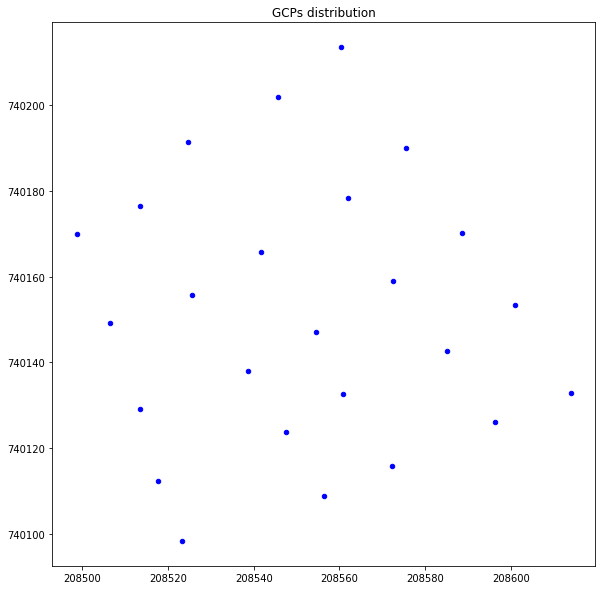

In [3]:
# 2D plot
gcp.plot(figsize=(10, 10), color='b', markersize=20)
plt.title('GCPs distribution')
plt.savefig('GCPs distribution.png')

In [4]:
# # 3D plot
# # option 1
# X, Y= np.meshgrid(df.x, df.y)
# Z = griddata((df['x'], df['y']), df['z'], (X, Y), method='cubic')
#
# fig = plt.figure()
# ax = Axes3D(fig)
# surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,linewidth=0, antialiased=False)
# plt.show()
#
# # option 2
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_trisurf(df.x, df.y, df.z, cmap=plt.cm.viridis, linewidth=0.2)
# plt.show()

In [5]:
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(df.x, df.y, df.z)
# plt.show()

In [6]:
def map_plot(geoDataFrame, crs=None, tiles=None):
    """

    :param geoDataFrame: GeoPandas.GeoDataFrame
    :param crs: coordinate system
    :param tile: “OpenStreetMap”
                “Mapbox Bright” (Limited levels of zoom for free tiles)
                “Mapbox Control Room” (Limited levels of zoom for free tiles)
                “Stamen” (Terrain, Toner, and Watercolor)
                “Cloudmade” (Must pass API key)
                “Mapbox” (Must pass API key)
                “CartoDB” (positron and dark_matter)
    :return: map with points
    """
    # convert from ITM to WGS84
    if crs == "EPSG:2039":
        interFeature = geoDataFrame.to_crs("+proj=tmerc +lat_0=31.7343936111111 +lon_0=35.2045169444445 +k=1.0000067 +x_0=219529.584 +y_0=626907.39 +ellps=GRS80 +towgs84=-23.772,-17.490,-17.859,-0.31320,-1.85274,1.67299,5.4262 +units=m +no_defs")
        crs_4326 =  {'init': 'epsg:4326'}
        geoDataFrame_4326 = interFeature.to_crs(crs_4326)

    # map
    lats = geoDataFrame_4326.geometry.y
    lons = geoDataFrame_4326.geometry.x
    names = geoDataFrame_4326.iloc[:,0]
    centrum = [lats.mean(),lons.mean()]

    if tiles == 'Esri':
        map=folium.Map(location=centrum,
                       tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                       attr = 'Esri',
                       name = 'Esri Satellite',
                       zoom_start=16)
    else:
        map=folium.Map(location=centrum, tiles=tiles,zoom_start=16)

    for lat,lon,name in zip(lats,lons,names):
        map.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name))))
    return map

In [7]:
map_plot(gcp,'EPSG:2039','OpenStreetMap')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
map_plot(gcp,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
map_plot(img,'EPSG:2039','Esri')

C:\Users\DELL\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Errors Analysis

Checking different configurations errors

In [10]:
# def plot_errors(points_file_path, arrow_size=1, GCP_gdf=None):
#     """
#     Get set of Check points and GCPs errors.
#     plot the horizontal error as arrows plot
#     and the vertical error depends on the distance from the nearest GCP.
#     :param points_file_path: file path of the check points
#     :param arrow_size: reference arrow size in meters
#     :param GCP_gdf: GeoDataFrame of the GCP.
#     :return: print error stat and plot the errors
#     """
#
#     rms = pd.read_csv(points_file_path)
#     # Create GoeDataFrame
#     points = gpd.points_from_xy(x=rms.x, y=rms.y)
#     rms['geometry'] = points
#     rms = gpd.GeoDataFrame(rms, geometry='geometry', crs="EPSG:2039")
#
#     # calculate horizontal error
#     for i,row in rms.iterrows():
#         rms.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2)
#     # print error stat
#     print('Horizontal errors statistics:','\n',rms['error'].describe(),'\n')
#     print('Vertical errors statistics:','\n',rms['Error Z'].describe())
#
#     # plot horizontal error
#     fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
#     q = axs[0].quiver(rms['x'], rms['y'], rms['Error X'], rms['Error Y'] )
#     axs[0].quiverkey(q, X=0.15, Y=0.9, U=arrow_size,
#                  label='Quiver key, length ='+str(arrow_size)+'[m]', labelpos='E')
#     axs[0].set_title('Horizontal Error')
#     axs[0].set_xlabel('x [m]')
#     axs[0].set_ylabel('y [m]')
#     axs[0].axis('equal')
#
#     # Case of GCPs
#     if GCP_gdf is not None :
#         # find the nearest GCP for every Check point
#         rms['nearest_gcp'] = rms.apply(nearest, gdf1=rms,
#                                      gdf2=GCP_gdf, geom_col1='geometry',geom_col2='geometry' , src_column='point', axis=1)
#
#         # Calc' the distances to the nearest GCP
#         for i,row in rms.iterrows():
#             nearest_name = rms.loc[i,'nearest_gcp']
#             nearest_point = rms.loc[(rms['point']==nearest_name)].geometry
#             dist = np.sqrt((rms.loc[i,'geometry'].x-nearest_point.x)**2+
#                            (rms.loc[i,'geometry'].y-nearest_point.y)**2).to_numpy()[0]
#             rms.loc[i,'distance_from_gcp'] = dist
#
#         # plot vertical error depends on distance from gcp
#         axs[1].scatter(rms['distance_from_gcp'],abs(rms['Error Z']), s=40, c='r', marker='X', alpha=0.6)
#         axs[1].set_title('Vertical Error depends on distance from gcp ')
#         axs[1].set_xlabel('distance from gcp [m]')
#         axs[1].set_ylabel('Vertical Error [m]')
#         # axs[1].axis('equal')
#
#     plt.show()

In [11]:
def plot_errors(points_file_path, arrow_size=1, GCP_gdf=None):
    """
    Get set of Check points and GCPs errors.
    plot the horizontal error as arrows plot
    and the vertical error depends on the distance from the nearest GCP.
    :param points_file_path: file path of the check points
    :param arrow_size: reference arrow size in meters
    :param GCP_gdf: GeoDataFrame of the GCP.
    :return: print error stat and plot the errors
    """

    rms = pd.read_csv(points_file_path)
    # Create GoeDataFrame
    points = gpd.points_from_xy(x=rms.x, y=rms.y)
    rms['geometry'] = points
    rms = gpd.GeoDataFrame(rms, geometry='geometry', crs="EPSG:2039")

    # calculate horizontal error
    for i,row in rms.iterrows():
        rms.loc[i,'error'] = np.sqrt(row['Error X']**2+row['Error Y']**2)
    # print error stat
    print('Horizontal errors statistics:','\n',rms['error'].describe(),'\n')
    print('Vertical errors statistics:','\n',rms['Error Z'].describe())

    # plot horizontal error
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    q = axs[0].quiver(rms['x'], rms['y'], rms['Error X'], rms['Error Y'] )
    axs[0].quiverkey(q, X=0.15, Y=0.9, U=arrow_size,
                 label='Quiver key, length ='+str(arrow_size)+'[m]', labelpos='E')

    axs[0].set_title('Horizontal Error')
    axs[0].set_xlabel('x [m]')
    axs[0].set_ylabel('y [m]')
    axs[0].axis('equal')

    # Case of GCPs
    if GCP_gdf is not None :
        axs[0].scatter(rms['x'], rms['y'], c='b', marker="o")
        axs[0].scatter(GCP_gdf['x'], GCP_gdf['y'], c='r', marker="^")

        # find the nearest GCP for every Check point
        rms['nearest_gcp'] = rms.apply(nearest, gdf1=rms,
                                     gdf2=GCP_gdf, geom_col1='geometry',geom_col2='geometry' , src_column='point', axis=1)

        # Calc' the distances to the nearest GCP
        for i,row in rms.iterrows():
            nearest_name = rms.loc[i,'nearest_gcp']
            nearest_point = rms.loc[(rms['point']==nearest_name)].geometry
            dist = np.sqrt((rms.loc[i,'geometry'].x-nearest_point.x)**2+
                           (rms.loc[i,'geometry'].y-nearest_point.y)**2).to_numpy()[0]
            rms.loc[i,'distance_from_gcp'] = dist

        # plot vertical error depends on distance from gcp
        axs[1].scatter(rms['distance_from_gcp'],abs(rms['Error Z']), s=40, c='r', marker='X', alpha=0.6)
        axs[1].set_title('Vertical Error depends on distance from gcp ')
        axs[1].set_xlabel('distance from gcp [m]')
        axs[1].set_ylabel('Vertical Error [m]')
        # axs[1].axis('equal')

    plt.show()

In [12]:
def nearest(row, gdf1, gdf2, geom_col1,geom_col2, src_column=None):
    """
    Find the nearest point and return the corresponding value from specified column
    :param row: row of gdf1
    :param gdf1: GeoDataFrame of points that we want to find their nearest point from gdf2
    :param gdf2: GeoDataFrame of points that we want to find the nearest point for them from gdf1
    :param geom_col1: Name of geometry column in df1
    :param geom_col2: Name of geometry column in df2
    :param src_column: Name of the column that contain the values
    :return: The values of the nearest points in new column of gdf1
    """
    geom_union = gdf2.geometry.unary_union
    # Find the geometry that is closest
    nearest_ = gdf2[geom_col2] == nearest_points(row[geom_col1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = gdf2.loc[nearest_,src_column].to_numpy()[0]
    return value

In [13]:
gcp = pd.read_csv(r'data\GCP.csv')

In [14]:
# Create GCPs GoeDataFrame
points = gpd.points_from_xy(x=gcp.x, y=gcp.y)
gcp['geometry'] = points
gcp = gpd.GeoDataFrame(gcp, geometry='geometry', crs="EPSG:2039")

No GCPs

Horizontal errors statistics: 
 count    25.000000
mean     10.271060
std       0.015211
min      10.249842
25%      10.259427
50%      10.268646
75%      10.281425
max      10.308521
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.786920
std       0.021233
min       0.742000
25%       0.776000
50%       0.791000
75%       0.800000
max       0.834000
Name: Error Z, dtype: float64


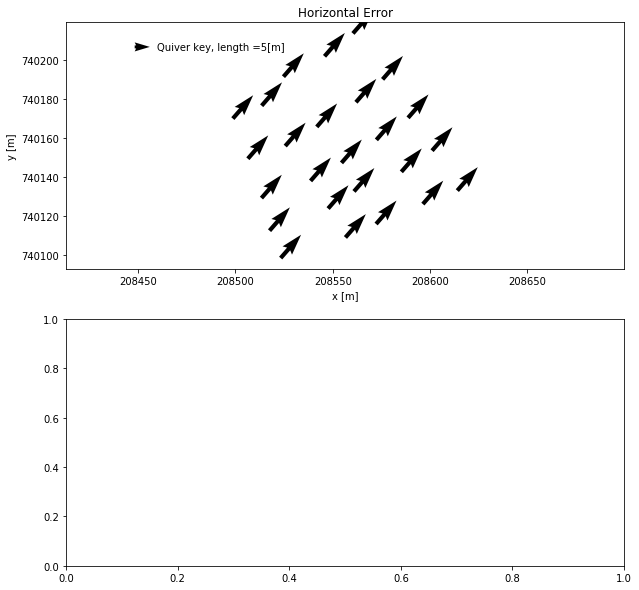

In [15]:
plot_errors(r'data\points_errors_No_GCP_acc.csv', 5)

Horizontal errors statistics: 
 count    25.000000
mean     10.301783
std       0.429323
min       9.559240
25%      10.030422
50%      10.278393
75%      10.615820
max      10.888339
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean    -24.961120
std       0.228652
min     -25.236000
25%     -25.117000
50%     -25.041000
75%     -24.774000
max     -24.477000
Name: Error Z, dtype: float64


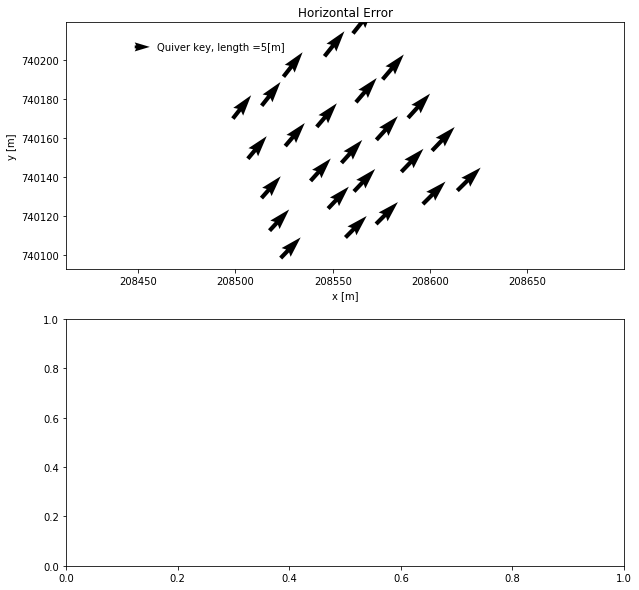

In [16]:
plot_errors(r'data\points_errors_No_GCP_Inacc.csv', 5)

1 GCP in the middle

Horizontal errors statistics: 
 count    25.000000
mean     10.267489
std       0.015413
min      10.246266
25%      10.255194
50%      10.265070
75%      10.277850
max      10.305699
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.702000
std       0.020787
min       0.660000
25%       0.691000
50%       0.705000
75%       0.714000
max       0.751000
Name: Error Z, dtype: float64


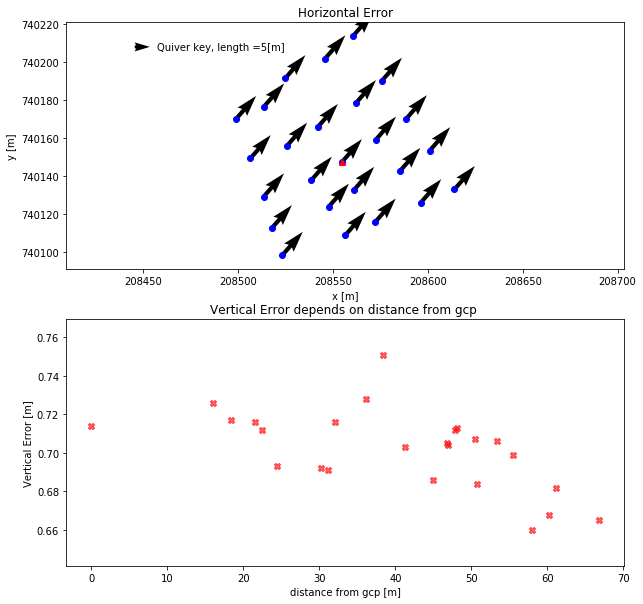

In [17]:
plot_errors(r'data\points_errors_1GCP_E_acc.csv', 5, gcp.loc[(gcp['point']=='p15')])

Horizontal errors statistics: 
 count    25.000000
mean      0.770806
std       0.327010
min       0.000000
25%       0.549524
50%       0.794081
75%       1.013138
max       1.344807
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.00000
mean      0.04128
std       3.64096
min      -5.97800
25%      -2.99200
50%       0.00000
75%       2.68900
max       7.18600
Name: Error Z, dtype: float64


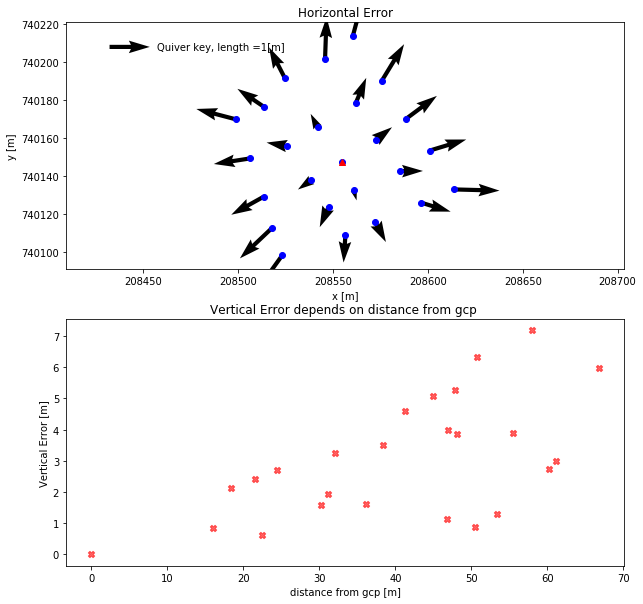

In [18]:
plot_errors(r'data\points_errors_1GCP_E_Inacc.csv', 1, gcp.loc[(gcp['point']=='p15')])

3 GCP in the middle

Horizontal errors statistics: 
 count    25.000000
mean      0.014977
std       0.007634
min       0.002470
25%       0.010885
50%       0.013822
75%       0.019694
max       0.037485
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.015592
std       0.022153
min      -0.064300
25%      -0.024500
50%      -0.011600
75%       0.000000
max       0.028900
Name: Error Z, dtype: float64


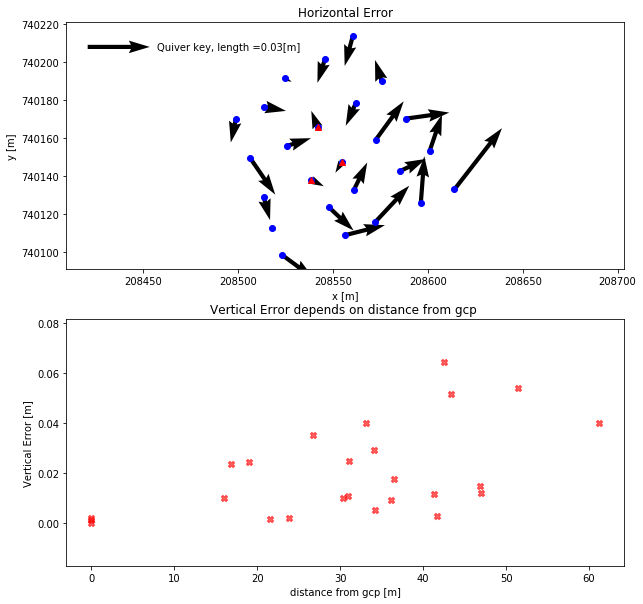

In [19]:
gcp_3=gcp.loc[(gcp['point'] == 'p15') | (gcp['point'] == 'p16') | (gcp['point'] == 'p19')]
plot_errors(r'data\points_errors_3GCP_m_acc.csv', 0.03, gcp_3)

Horizontal errors statistics: 
 count    25.000000
mean      0.016735
std       0.007237
min       0.005000
25%       0.011486
50%       0.017042
75%       0.021602
max       0.029983
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.253960
std       0.209799
min       0.000000
25%       0.108200
50%       0.234600
75%       0.375400
max       0.798400
Name: Error Z, dtype: float64


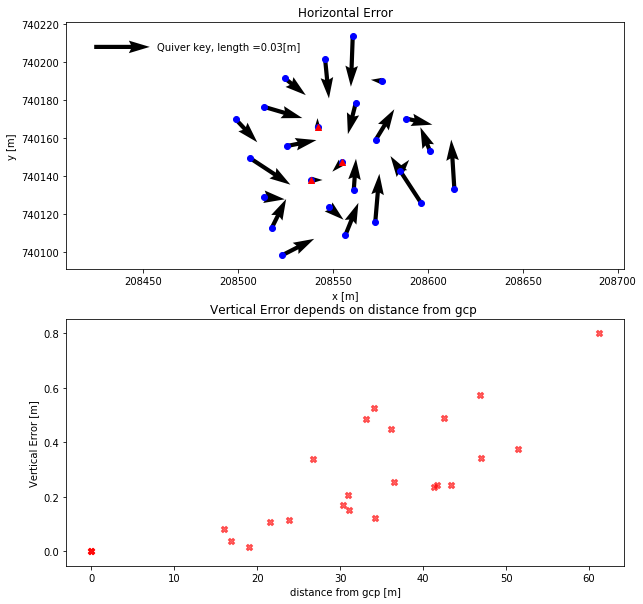

In [20]:
plot_errors(r'data\points_errors_3GCP_m_Inacc.csv', 0.03, gcp_3)

5 GCPs in the edge 1

Horizontal errors statistics: 
 count    25.000000
mean      0.016908
std       0.007429
min       0.004123
25%       0.011543
50%       0.014765
75%       0.021714
max       0.029686
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.000112
std       0.021999
min      -0.049400
25%      -0.009200
50%       0.006000
75%       0.015100
max       0.039700
Name: Error Z, dtype: float64


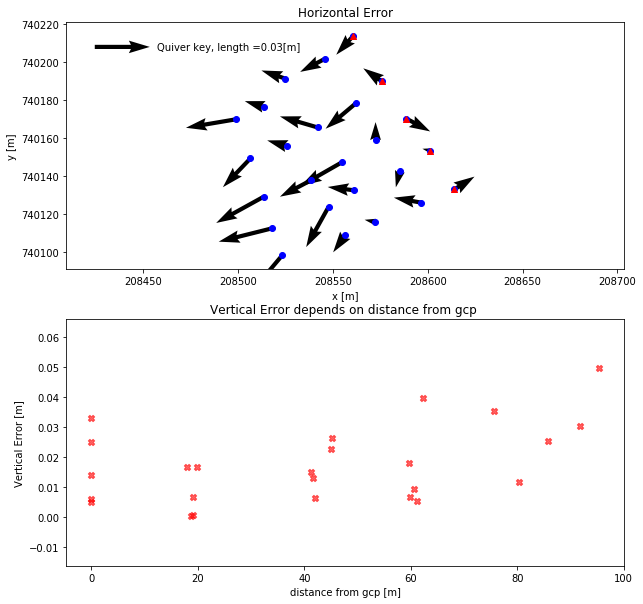

In [21]:
plot_errors(r'data\points_errors_5GCP_E1_acc.csv', 0.03, gcp.iloc[4:9,:])

Horizontal errors statistics: 
 count    25.000000
mean      0.021259
std       0.011484
min       0.000000
25%       0.013416
50%       0.021306
75%       0.027394
max       0.046710
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.250880
std       0.189538
min      -0.597200
25%      -0.389100
50%      -0.258400
75%      -0.103800
max       0.008000
Name: Error Z, dtype: float64


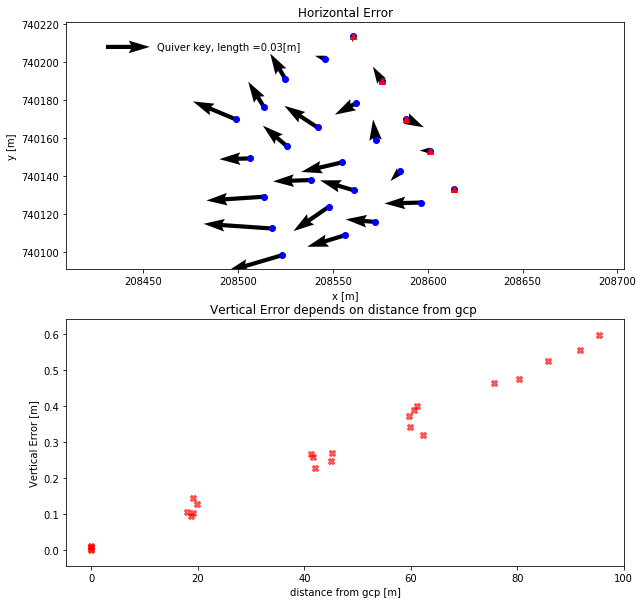

In [22]:
plot_errors(r'data\points_errors_5GCP_E1_Inacc.csv', 0.03, gcp.iloc[4:9,:] )

5 GCPs in the edge 2

Horizontal errors statistics: 
 count    25.000000
mean      0.013281
std       0.007201
min       0.003677
25%       0.008160
50%       0.011538
75%       0.019611
max       0.029202
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.005676
std       0.022070
min      -0.042000
25%      -0.002400
50%       0.009900
75%       0.022400
max       0.040000
Name: Error Z, dtype: float64


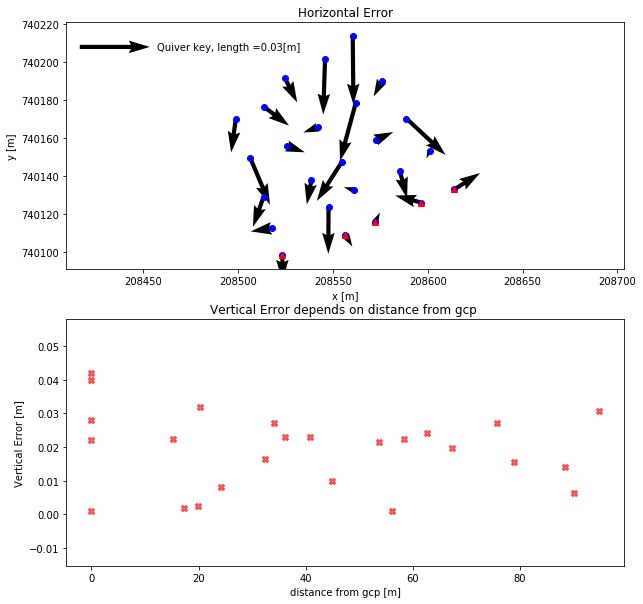

In [23]:
plot_errors(r'data\points_errors_5GCP_E2_acc.csv', 0.03, gcp.iloc[0:5,:])

Horizontal errors statistics: 
 count    25.000000
mean      0.011975
std       0.007770
min       0.000608
25%       0.007071
50%       0.010730
75%       0.017839
max       0.027323
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.294164
std       0.280619
min      -0.028100
25%       0.035700
50%       0.232300
75%       0.457100
max       0.812300
Name: Error Z, dtype: float64


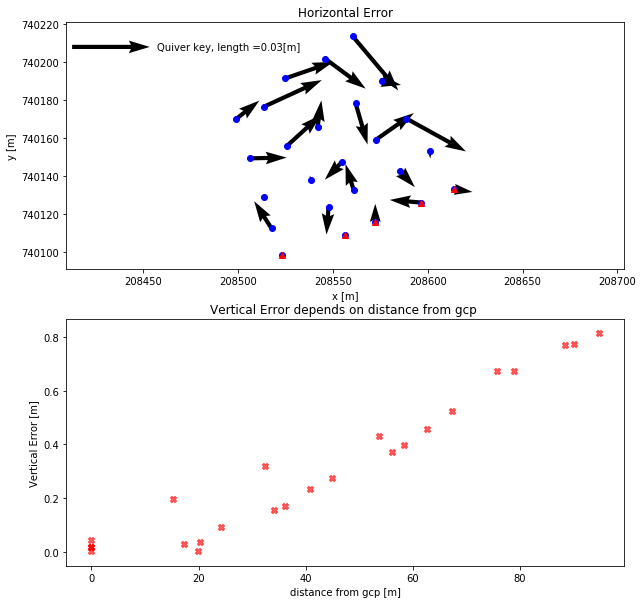

In [24]:
plot_errors(r'data\points_errors_5GCP_E2_Inacc.csv', 0.03, gcp.iloc[0:5,:])

4 GCPs in the corners

In [25]:
# choose 4 gcps from the corners
gcp_4=gcp.loc[(gcp['point'] == 'p1') | (gcp['point'] == 'p5') |
              (gcp['point'] == 'p9') | (gcp['point'] == 'p22')]

Horizontal errors statistics: 
 count    25.000000
mean      0.010714
std       0.004696
min       0.002326
25%       0.007086
50%       0.009719
75%       0.013800
max       0.018601
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.035016
std       0.022844
min      -0.013000
25%       0.027900
50%       0.037200
75%       0.051900
max       0.075200
Name: Error Z, dtype: float64


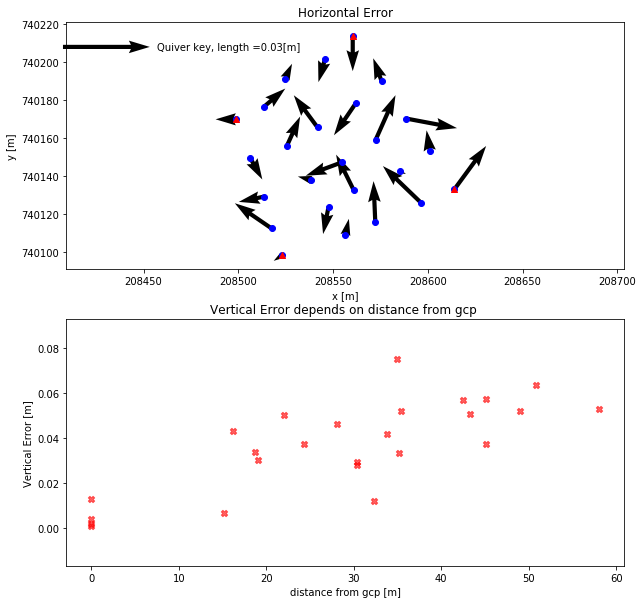

In [26]:
plot_errors(r'data\points_errors_4GCP_E_acc.csv', 0.03, gcp_4)

Horizontal errors statistics: 
 count    25.000000
mean      0.010234
std       0.004667
min       0.003960
25%       0.006230
50%       0.009801
75%       0.012492
max       0.022291
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.255732
std       0.195617
min      -0.540000
25%      -0.448800
50%      -0.238100
75%      -0.101300
max       0.013900
Name: Error Z, dtype: float64


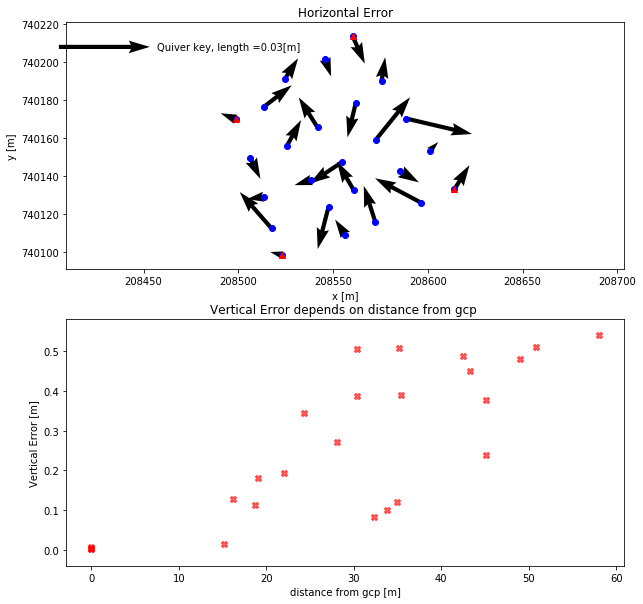

In [27]:
plot_errors(r'data\points_errors_4GCP_E_Inacc.csv', 0.03, gcp_4)

9 GCPs in 2 Edges

Horizontal errors statistics: 
 count    25.000000
mean      0.011600
std       0.005465
min       0.001360
25%       0.006648
50%       0.012602
75%       0.017007
max       0.018392
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean      0.000848
std       0.020882
min      -0.043000
25%      -0.008300
50%       0.002000
75%       0.016300
max       0.038000
Name: Error Z, dtype: float64


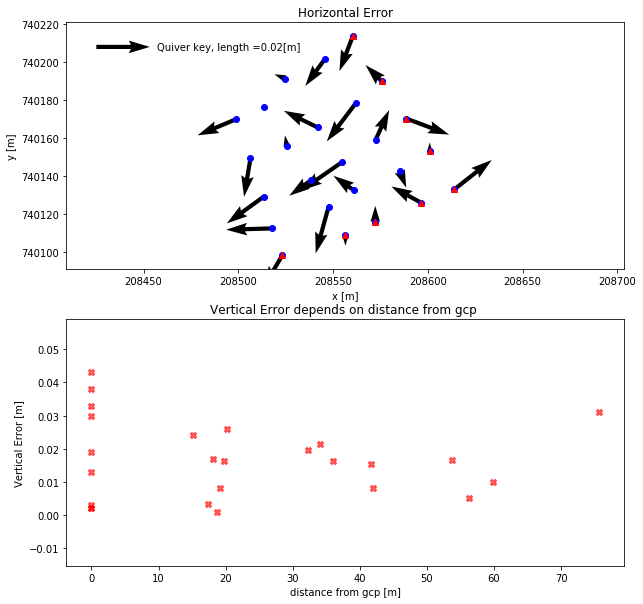

In [28]:
plot_errors(r'data\points_errors_9GCP_E1-2_acc.csv', 0.02, gcp.iloc[0:9,:])

Horizontal errors statistics: 
 count    25.000000
mean      0.011088
std       0.004697
min       0.002236
25%       0.006708
50%       0.011314
75%       0.014327
max       0.018950
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.009016
std       0.017472
min      -0.034400
25%      -0.023700
50%      -0.011200
75%       0.003000
max       0.022700
Name: Error Z, dtype: float64


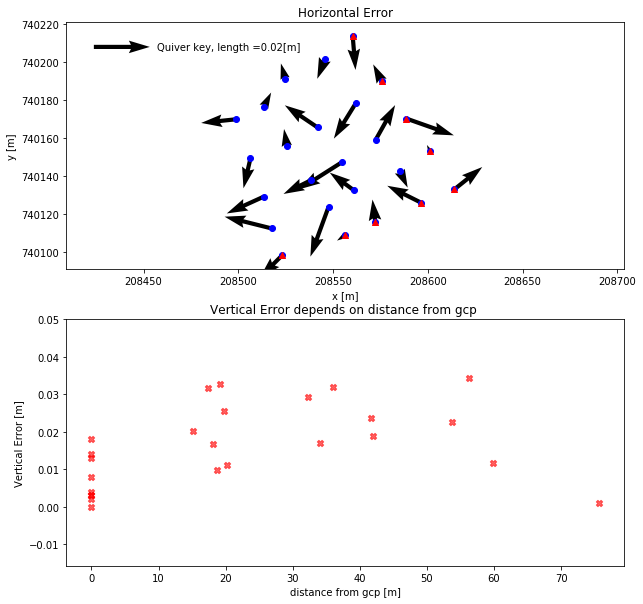

In [29]:
plot_errors(r'data\points_errors_9GCP_E1-2_Inacc.csv', 0.02, gcp.iloc[0:9,:])

All GCPs

Horizontal errors statistics: 
 count    25.000000
mean      0.010164
std       0.004539
min       0.002236
25%       0.007071
50%       0.009487
75%       0.012806
max       0.019849
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.00000
mean     -0.00248
std       0.01989
min      -0.04200
25%      -0.01300
50%      -0.00400
75%       0.01100
max       0.03600
Name: Error Z, dtype: float64


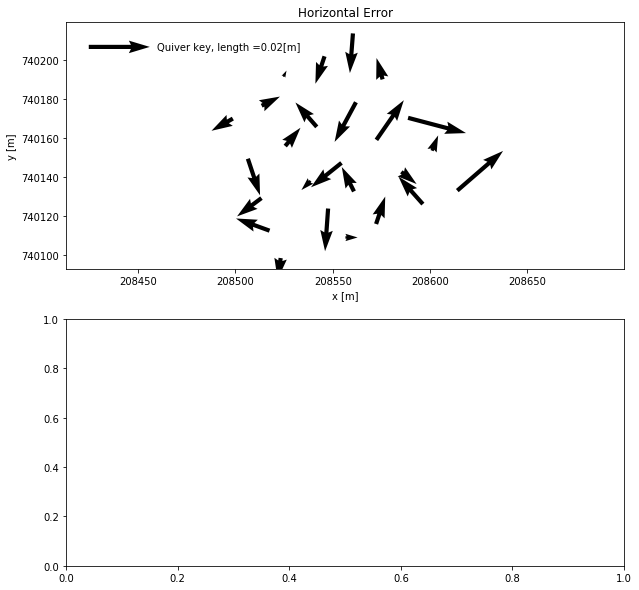

In [30]:
plot_errors(r'data\points_errors_allGCP_acc.csv', 0.02)

Horizontal errors statistics: 
 count    25.000000
mean      0.009631
std       0.004468
min       0.001000
25%       0.006325
50%       0.009434
75%       0.013000
max       0.018974
Name: error, dtype: float64 

Vertical errors statistics: 
 count    25.000000
mean     -0.001040
std       0.013331
min      -0.018000
25%      -0.013000
50%      -0.003000
75%       0.006000
max       0.035000
Name: Error Z, dtype: float64


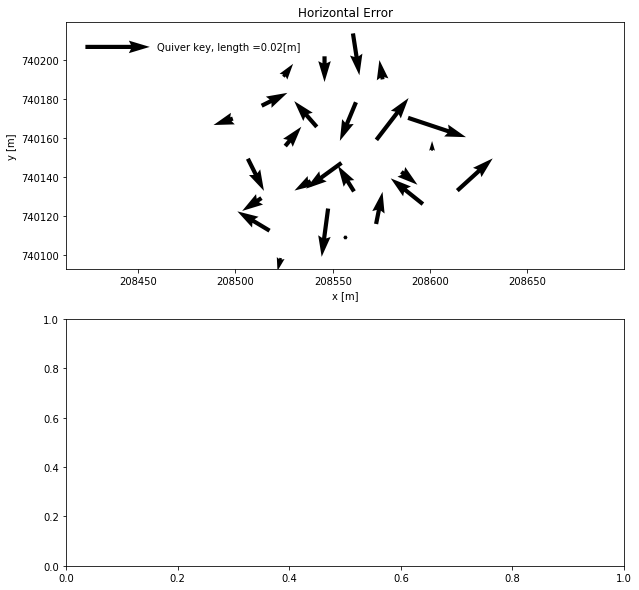

In [31]:
plot_errors(r'data\points_errors_allGCP_Inacc.csv', 0.02)


In [32]:
!jupyter nbconvert  geo_project.ipynb --to html

[NbConvertApp] Converting notebook geo_project.ipynb to html
[NbConvertApp] Writing 305813 bytes to geo_project.html
